<a href="https://colab.research.google.com/github/james-ott-csuglobal/KNN_Auto_Supp_Resis/blob/main/KNN_SnR_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
!pip install mpl_finance

     |████████████████████████████████| 5.5MB 7.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=33e3d8fbeccdefa481f6afbbc6fce3cb014ecd4e5f4da126b652a068b0615213
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [24]:
import numpy as np
import yfinance as yf
from datetime import datetime, date
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import time

In [25]:
def load_prices(ticker, period="6mo"):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval="1d")
    first = data['Open'].iloc[0]
    last = data['Close'].iloc[-1]
    chg = ((last - first)/first)*100
    chg = "{:.2f}".format(chg)
    df1 = pd.DataFrame()
    df1['ticker'] = [ticker]
    df1['last_price'] = [last]
    df1['daily_chg'] = [chg]
    return data

def get_info(ticker):
  stock = yf.Ticker(ticker)
  return stock.info

def closing_price(df, colname='Close', place=-1):
  x = df[colname].iloc[place]
  return x




In [26]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(15, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

In [27]:
symbol = 'TSLA'

In [32]:
df_s = load_prices(symbol, "6mo")

# df_s = load_prices(symbol, "1mo")
# df_s = load_prices(symbol, "3mo")
# df_s = load_prices(symbol, "6mo")
# df_s = load_prices(symbol, "1y")

df_s = df_s.rename_axis('Date').reset_index()
df_s.tail(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
125,2020-12-29,661.00000,669.900024,655.000000,665.989990,22910800,0,0.0
126,2020-12-30,672.00000,696.599976,668.359985,694.780029,42846000,0,0.0
127,2020-12-31,699.98999,718.719971,691.119995,705.669983,49570900,0,0.0


In [33]:
df_s.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-07-01,216.600006,227.065994,216.100006,223.925995,13326900,0,0.0
1,2020-07-02,244.296005,245.600006,237.119995,241.731995,17250100,0,0.0
2,2020-07-06,255.337997,275.558014,253.207993,274.316010,102849500,0,0.0


In [37]:
data = df_s

df_s1 = df_s.drop('Date', axis=1)

lows = pd.DataFrame(data=df_s1, index=data.index, columns=["Low"])
highs = pd.DataFrame(data=df_s1, index=data.index, columns=["High"])

low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

lowss = []
highss = []
finals = []

rounding_factor = 0

for i in low_centers:
  i = round(float(i),rounding_factor)
  lowss.append(i)

for i in high_centers:
  i = round(float(i),rounding_factor)
  highss.append(i)

print('lows/support: ', lowss)
print('highs/resistence: ', highss)

##
if len(lowss) != len(highss):
  finals = lowss + highss
else:
  for i in range(len(lowss)):
      l1 = lowss[i]
      h1 = highss[i]
      if i != (len(lowss) - 1):
        l2 = lowss[i+1]
        if ((h1 - l1) < (l2 - l1)):
          finals.append((h1+l1)/2)
        else:
          finals.append(l1)
      else:
        finals.append(highss[i])

print('finals/blended:',finals)


Optimum K is 14
Optimum K is 14
lows/support:  [227.0, 269.0, 292.0, 324.0, 370.0, 404.0, 422.0, 438.0, 487.0, 542.0, 581.0, 616.0, 654.0, 691.0]
highs/resistence:  [236.0, 285.0, 307.0, 332.0, 374.0, 411.0, 432.0, 456.0, 506.0, 569.0, 600.0, 628.0, 655.0, 698.0]
finals/blended: [231.5, 277.0, 299.5, 328.0, 372.0, 407.5, 427.0, 447.0, 496.5, 555.5, 590.5, 622.0, 654.5, 698.0]


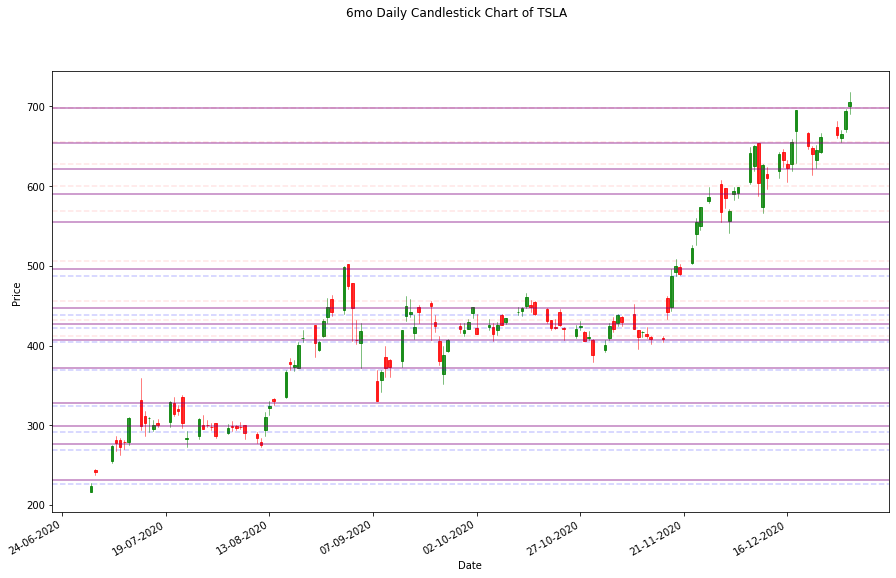

In [41]:
plt.style.use('fast')

# Extracting Data for plotting
data = df_s
ohlc = data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots(figsize=(15,9))

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('6mo Daily Candlestick Chart of ' + symbol)

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

# fig.tight_layout()

# plt.show()


for low in low_centers[:9]:
    ax.axhline(low[0], color='blue', ls='--', alpha=.2)

for high in high_centers[-9:]:
    ax.axhline(high[0], color='red', ls='--', alpha=.1)

for final in finals:
    ax.axhline(final, color='purple', ls='-',alpha=.5)

